Name: Syed Mohamad Tawseeq          
ROll: 22CH10090

a) Implement a Simple CNN (25 Marks)

Note: In this repo i build soem loops and reused them but explained them only once with comments in the beginning

In [2]:
import torch

In [3]:
torch.cuda.is_available()

True

In [8]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn

In [4]:
transform = transforms.Compose([ # transform is defined first and then is passed as an argument   while loading the dataset
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616)
    )
])
train_dataset = datasets.CIFAR10(     #loading dataset as by default documentation on pytorch website
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)


100%|██████████| 170M/170M [00:03<00:00, 43.3MB/s]


In [5]:

train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
           )

In [6]:
classes = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}
selected_classes = [0, 1, 2] # we choose first 3 classes only for the first experiment

indices = [i for i, (_, label) in enumerate(train_dataset) if label in selected_classes]  #here we only chose the examples that have those three selected labels
train_subset =  Subset(train_dataset, indices)
indices = [i for i, (_, label) in enumerate(test_dataset) if label in selected_classes]
test_subset =  Subset(test_dataset, indices)


In [7]:
train_loader = DataLoader( #dataloader converts the data into proper format of pytorch tensors so that it can be processed
    train_subset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_subset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

In [8]:
import torch.nn as nn
class MyCNN(nn.Module):  #this is my base architecture
    def __init__(self):
        super().__init__()
        self.conv2d_1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2d_2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2) #added maxpooling
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv2d_1(x)))  # → [B, 6, 14, 14]
        x = self.pool(torch.relu(self.conv2d_2(x)))  # → [B, 16, 5, 5]
        x = x.view(x.size(0), -1) #flattening for input in fc layer
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [9]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyCNN().to(device) #moving the model to device
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
train_losses = []
train_accs = []
test_accs = []

epochs = 10
print(f"Device = {device}") #check the ddevice
for epoch in range(epochs):
    model.train() #set the model in training mode
    correct, total, running_loss = 0, 0, 0.0  #for some metrics
    for images, labels in train_loader:
      # we loop over all training examples in train loader
        images, labels = images.to(device), labels.to(device) #move the data to device else we cant compute
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    model.eval() #set into eval mode
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = 100 * correct / total

    train_losses.append(loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch numb[{epoch+1}/{epochs}] Loss: {loss}, Train Accuracy: {train_acc}%, Test Accuracy : {test_acc}%")



Device = cuda
Epoch numb[1/10] Loss: 0.6555754312809478, Train Accuracy: 72.95333333333333%, Test Accuracy : 78.73333333333333%
Epoch numb[2/10] Loss: 0.4998694818070594, Train Accuracy: 80.16666666666667%, Test Accuracy : 82.4%
Epoch numb[3/10] Loss: 0.43311367294889813, Train Accuracy: 82.95333333333333%, Test Accuracy : 84.4%
Epoch numb[4/10] Loss: 0.3837834987234562, Train Accuracy: 84.92666666666666%, Test Accuracy : 85.76666666666667%
Epoch numb[5/10] Loss: 0.35193566787750163, Train Accuracy: 86.32%, Test Accuracy : 84.73333333333333%
Epoch numb[6/10] Loss: 0.32847623641186574, Train Accuracy: 87.28666666666666%, Test Accuracy : 85.63333333333334%
Epoch numb[7/10] Loss: 0.30481850609500355, Train Accuracy: 88.26666666666667%, Test Accuracy : 84.96666666666667%
Epoch numb[8/10] Loss: 0.28106022106206163, Train Accuracy: 89.06666666666666%, Test Accuracy : 87.06666666666666%
Epoch numb[9/10] Loss: 0.26217520227457614, Train Accuracy: 89.98666666666666%, Test Accuracy : 87.5%
Epoch

Text(0, 0.5, 'Loss')

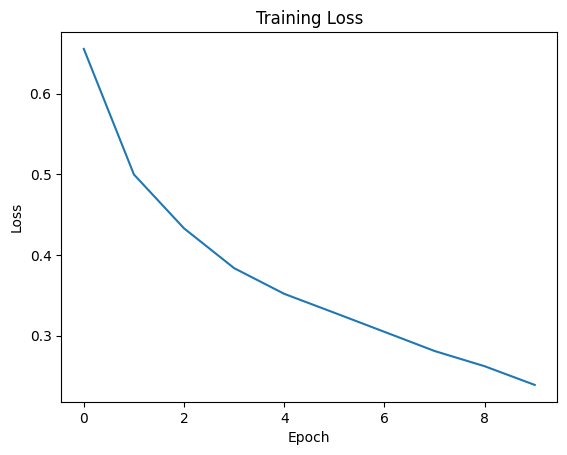

In [11]:

plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy (%)')

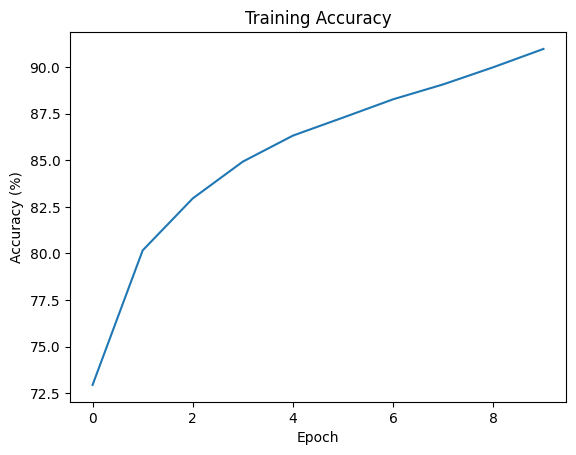

In [12]:
plt.plot(train_accs)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

Text(0, 0.5, 'Accuracy (%)')

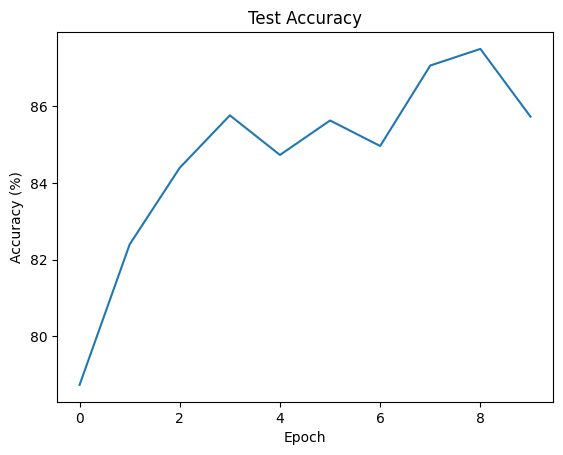

In [13]:
plt.plot(test_accs)
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

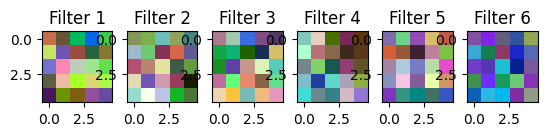

In [ ]:
filters = model.conv2d_1.weight.data.cpu() #this is used to see the weuights, moved to cpu, else we cant use numpy
fig, axes = plt.subplots(1, 6)
for i in range(6):
    f = filters[i]
    f = (f - f.min()) / (f.max() - f.min()) #min max norm, imshow expects values roughly in 0, 1 range
    axes[i].imshow(f.permute(1,2,0)) #(channel, height, width) -> (height, width, channel)
    axes[i].set_title(f"Filter {i+1}")

plt.show()


***(b) Ablations (40 marks) – Perform each ablation separately basing it on the architecture in (a). For example, if increase in convolutional layers by 1 means increasing it from 2 to 3 (because we had 2 convolutional layers in (a). Don’t repeat any experiments from (a).***


Train on the Full CIFAR-10 Dataset (10 marks)

In [ ]:
train_loader = DataLoader(
    train_dataset, #we use full dataset here
    batch_size=64,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

In [ ]:
class My_new_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2d_1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2d_2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv2d_1(x)))  
        x = self.pool(torch.relu(self.conv2d_2(x)))  
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [17]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = My_new_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
train_losses = []
train_accs = []
test_accs = []

epochs = 10
print(f"Device = {device}")
for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = 100 * correct / total

    train_losses.append(loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch numb[{epoch+1}/{epochs}] Loss: {loss}, Train Accuracy: {train_acc}%, Test Accuracy : {test_acc}%")


Device = cuda
Epoch numb[1/10] Loss: 1.6229931425560467, Train Accuracy: 40.456%, Test Accuracy : 50.69%
Epoch numb[2/10] Loss: 1.305902274749468, Train Accuracy: 53.088%, Test Accuracy : 54.79%
Epoch numb[3/10] Loss: 1.1929364948321486, Train Accuracy: 57.674%, Test Accuracy : 58.58%
Epoch numb[4/10] Loss: 1.1094166063286763, Train Accuracy: 60.712%, Test Accuracy : 58.21%
Epoch numb[5/10] Loss: 1.0548811403229414, Train Accuracy: 62.556%, Test Accuracy : 60.03%
Epoch numb[6/10] Loss: 1.0045246158719368, Train Accuracy: 64.368%, Test Accuracy : 61.49%
Epoch numb[7/10] Loss: 0.9604200137698132, Train Accuracy: 66.134%, Test Accuracy : 62.24%
Epoch numb[8/10] Loss: 0.9282602981075911, Train Accuracy: 67.24%, Test Accuracy : 62.39%
Epoch numb[9/10] Loss: 0.8851905278385143, Train Accuracy: 68.846%, Test Accuracy : 63.66%
Epoch numb[10/10] Loss: 0.8544219249044843, Train Accuracy: 69.898%, Test Accuracy : 63.41%


Modify the CNN architecture and compare accuracy across architectures (10 marks)

In [ ]:
def training_loop(model, device, train_loader, test_loader, epochs= 10): #components are explained in previous training loop
  train_losses = []
  train_accs = []
  test_accs = []

  print(f"Device = {device}")
  for epoch in range(epochs):
      model.train()
      correct, total, running_loss = 0, 0, 0.0
      for images, labels in train_loader:
          images, labels = images.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()

      loss = running_loss / len(train_loader)
      train_acc = 100 * correct / total

      model.eval()
      correct, total = 0, 0

      with torch.no_grad():
          for images, labels in test_loader:
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              _, predicted = outputs.max(1)
              total += labels.size(0)
              correct += predicted.eq(labels).sum().item()

      test_acc = 100 * correct / total

      train_losses.append(loss)
      train_accs.append(train_acc)
      test_accs.append(test_acc)

      print(f"Epoch numb[{epoch+1}/{epochs}] Loss: {loss}, Train Accuracy: {train_acc}%, Test Accuracy : {test_acc}%")
  return train_losses, train_accs, test_accs

In [ ]:
class My_arch_change_CNN(nn.Module): #one conv less kernal size 3
    #components are explained in previous training loop
    def __init__(self, kernal_size = 3):
        super().__init__()
        self.conv2d_1 = nn.Conv2d(3, 16, kernel_size=3)
        # self.conv2d_2 = nn.Conv2d(6, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*15*15, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv2d_1(x)))
        # x = self.pool(torch.relu(self.conv2d_2(x)))  
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = My_arch_change_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accs = []
test_accs = []

epochs = 10
print(f"Device = {device}")
for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = 100 * correct / total

    train_losses.append(loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch numb[{epoch+1}/{epochs}] Loss: {loss}, Train Accuracy: {train_acc}%, Test Accuracy : {test_acc}%")




Device = cuda
Epoch numb[1/10] Loss: 1.4368870117322867, Train Accuracy: 48.256%, Test Accuracy : 56.14%
Epoch numb[2/10] Loss: 1.1408360002900633, Train Accuracy: 59.686%, Test Accuracy : 59.58%
Epoch numb[3/10] Loss: 0.9966519436110621, Train Accuracy: 64.576%, Test Accuracy : 63.48%
Epoch numb[4/10] Loss: 0.8804556985797785, Train Accuracy: 68.798%, Test Accuracy : 64.29%
Epoch numb[5/10] Loss: 0.7802591893983923, Train Accuracy: 72.354%, Test Accuracy : 64.7%
Epoch numb[6/10] Loss: 0.695354635148402, Train Accuracy: 75.546%, Test Accuracy : 65.64%
Epoch numb[7/10] Loss: 0.6222018096453089, Train Accuracy: 77.97%, Test Accuracy : 65.17%
Epoch numb[8/10] Loss: 0.5442189885603498, Train Accuracy: 80.946%, Test Accuracy : 64.96%
Epoch numb[9/10] Loss: 0.48595147808570693, Train Accuracy: 82.708%, Test Accuracy : 65.12%
Epoch numb[10/10] Loss: 0.4257193856570117, Train Accuracy: 84.946%, Test Accuracy : 64.28%


In [ ]:
class My_arch_change_CNN(nn.Module): #one conv less kernal size 7
    #components are explained in previous training loop
    def __init__(self):
        super().__init__()
        self.conv2d_1 = nn.Conv2d(3, 16, kernel_size=7)
        # self.conv2d_2 = nn.Conv2d(6, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*13*13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv2d_1(x)))  
        # x = self.pool(torch.relu(self.conv2d_2(x))) 
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = My_arch_change_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accs = []
test_accs = []

epochs = 10
print(f"Device = {device}")
for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = 100 * correct / total

    train_losses.append(loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch numb[{epoch+1}/{epochs}] Loss: {loss}, Train Accuracy: {train_acc}%, Test Accuracy : {test_acc}%")




Device = cuda
Epoch numb[1/10] Loss: 1.49084499562183, Train Accuracy: 46.364%, Test Accuracy : 55.34%
Epoch numb[2/10] Loss: 1.1751182757680068, Train Accuracy: 58.392%, Test Accuracy : 59.43%
Epoch numb[3/10] Loss: 1.0324960158913947, Train Accuracy: 63.622%, Test Accuracy : 61.66%
Epoch numb[4/10] Loss: 0.9363341650846974, Train Accuracy: 66.914%, Test Accuracy : 64.61%
Epoch numb[5/10] Loss: 0.8551199403412811, Train Accuracy: 69.886%, Test Accuracy : 63.13%
Epoch numb[6/10] Loss: 0.792803274053137, Train Accuracy: 71.862%, Test Accuracy : 64.58%
Epoch numb[7/10] Loss: 0.7345023383874723, Train Accuracy: 74.074%, Test Accuracy : 65.07%
Epoch numb[8/10] Loss: 0.6824009504235918, Train Accuracy: 75.778%, Test Accuracy : 65.77%
Epoch numb[9/10] Loss: 0.6341289496025466, Train Accuracy: 77.468%, Test Accuracy : 65.07%
Epoch numb[10/10] Loss: 0.5876031758459023, Train Accuracy: 79.206%, Test Accuracy : 65.37%


In [ ]:
class My_arch_change_CNN(nn.Module): #one conv more kernal size 3
    #components are explained in previous training loop
    def __init__(self, kernal_size = 3):
        super().__init__()
        self.conv2d_1 = nn.Conv2d(3, 6, kernel_size=3)
        self.conv2d_2 = nn.Conv2d(6, 10, kernel_size=3)
        self.conv2d_3 = nn.Conv2d(10, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*2*2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv2d_1(x))) 
        x = self.pool(torch.relu(self.conv2d_2(x))) 
        x = self.pool(torch.relu(self.conv2d_3(x))) 
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = My_arch_change_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accs = []
test_accs = []

epochs = 10
print(f"Device = {device}")
for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = 100 * correct / total

    train_losses.append(loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch numb[{epoch+1}/{epochs}] Loss: {loss}, Train Accuracy: {train_acc}%, Test Accuracy : {test_acc}%")




Device = cuda
Epoch numb[1/10] Loss: 1.7546708844506833, Train Accuracy: 35.0%, Test Accuracy : 42.57%
Epoch numb[2/10] Loss: 1.4803683777599383, Train Accuracy: 46.026%, Test Accuracy : 48.47%
Epoch numb[3/10] Loss: 1.3786260661719096, Train Accuracy: 49.874%, Test Accuracy : 50.59%
Epoch numb[4/10] Loss: 1.312077248492814, Train Accuracy: 52.678%, Test Accuracy : 53.63%
Epoch numb[5/10] Loss: 1.262373418454319, Train Accuracy: 54.796%, Test Accuracy : 53.67%
Epoch numb[6/10] Loss: 1.222637323086219, Train Accuracy: 56.508%, Test Accuracy : 54.95%
Epoch numb[7/10] Loss: 1.19235346132837, Train Accuracy: 57.616%, Test Accuracy : 56.98%
Epoch numb[8/10] Loss: 1.1628601441297994, Train Accuracy: 58.414%, Test Accuracy : 56.57%
Epoch numb[9/10] Loss: 1.1377204541507584, Train Accuracy: 59.52%, Test Accuracy : 57.38%
Epoch numb[10/10] Loss: 1.1134320986087975, Train Accuracy: 60.372%, Test Accuracy : 58.18%


In [ ]:
#Add dropout layers after each convolutional layer. (4 marks)
class My_arch_drop_CNN(nn.Module):
    #components are explained in previous training loop
    def __init__(self, kernal_size = 3):
        super().__init__()
        self.conv2d_1 = nn.Conv2d(3, 6, kernel_size=3)
        self.conv2d_2 = nn.Conv2d(6, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(16*6*6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(self.dropout(torch.relu(self.conv2d_1(x))))  
        x = self.pool(self.dropout(torch.relu(self.conv2d_2(x)))) 
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = My_arch_drop_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accs = []
test_accs = []

epochs = 10
print(f"Device = {device}")
for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = 100 * correct / total

    train_losses.append(loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch numb[{epoch+1}/{epochs}] Loss: {loss}, Train Accuracy: {train_acc}%, Test Accuracy : {test_acc}%")

Device = cuda
Epoch numb[1/10] Loss: 1.8346957492706415, Train Accuracy: 34.152%, Test Accuracy : 44.92%
Epoch numb[2/10] Loss: 1.621596558014755, Train Accuracy: 41.96%, Test Accuracy : 49.95%
Epoch numb[3/10] Loss: 1.529302543691357, Train Accuracy: 45.458%, Test Accuracy : 53.75%
Epoch numb[4/10] Loss: 1.4679593600885337, Train Accuracy: 47.838%, Test Accuracy : 54.43%
Epoch numb[5/10] Loss: 1.4160451273174237, Train Accuracy: 49.91%, Test Accuracy : 55.79%
Epoch numb[6/10] Loss: 1.3813767680884017, Train Accuracy: 51.066%, Test Accuracy : 56.75%
Epoch numb[7/10] Loss: 1.3482713888368338, Train Accuracy: 52.226%, Test Accuracy : 57.45%
Epoch numb[8/10] Loss: 1.3221527530104302, Train Accuracy: 53.354%, Test Accuracy : 57.61%
Epoch numb[9/10] Loss: 1.2962030180732307, Train Accuracy: 54.22%, Test Accuracy : 58.56%
Epoch numb[10/10] Loss: 1.2784666992971658, Train Accuracy: 55.12%, Test Accuracy : 59.86%


Experiment with Different Optimizers (10 marks)

In [ ]:
#components are explained in previous training loop

In [ ]:

class MyCNN(nn.Module):
        #components are explained in previous training loop
    def __init__(self):
        super().__init__()
        self.conv2d_1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2d_2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv2d_1(x))) 
        x = self.pool(torch.relu(self.conv2d_2(x))) 

        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#we write training loops 4 times in single block with doifferent optimizers and new model initialization everytime
model = MyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_lossAdam, train_accsAdam, test_accsAdam = training_loop(model, device, train_loader, test_loader)

model = MyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
train_lossSGD, train_accsSGD, test_accsSGD = training_loop(model, device, train_loader, test_loader)

model = MyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
train_lossRMSprop, train_accsRMSprop, test_accsRMSprop = training_loop(model, device, train_loader, test_loader)

model = MyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.001)
train_lossAdamax, train_accsAdamax, test_accsAdamax = training_loop(model, device, train_loader, test_loader)

Device = cuda
Epoch numb[1/10] Loss: 1.6264883784381934, Train Accuracy: 40.396%, Test Accuracy : 49.94%
Epoch numb[2/10] Loss: 1.3316886864049966, Train Accuracy: 51.912%, Test Accuracy : 52.65%
Epoch numb[3/10] Loss: 1.2075044159846537, Train Accuracy: 56.934%, Test Accuracy : 56.72%
Epoch numb[4/10] Loss: 1.129931701723572, Train Accuracy: 59.972%, Test Accuracy : 59.39%
Epoch numb[5/10] Loss: 1.0634295232308186, Train Accuracy: 62.294%, Test Accuracy : 61.0%
Epoch numb[6/10] Loss: 1.0139192846577492, Train Accuracy: 64.104%, Test Accuracy : 62.72%
Epoch numb[7/10] Loss: 0.9740497705424228, Train Accuracy: 65.596%, Test Accuracy : 61.97%
Epoch numb[8/10] Loss: 0.9316701123019313, Train Accuracy: 67.05%, Test Accuracy : 62.75%
Epoch numb[9/10] Loss: 0.8967538882247017, Train Accuracy: 68.384%, Test Accuracy : 64.29%
Epoch numb[10/10] Loss: 0.8656379544673978, Train Accuracy: 69.29%, Test Accuracy : 63.97%
Device = cuda
Epoch numb[1/10] Loss: 2.3058504082662674, Train Accuracy: 9.894%

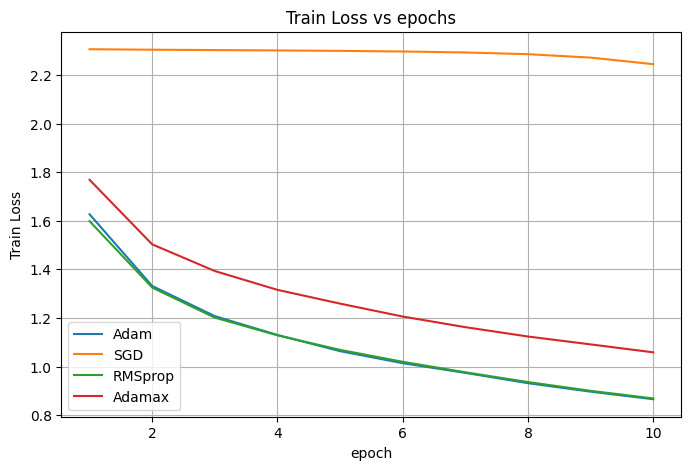

In [ ]:
epochs = range(1, len(train_lossAdam) + 1)
#we visualize it using plots
plt.figure(figsize=(8,5))
plt.plot(epochs, train_lossAdam, label="Adam")
plt.plot(epochs, train_lossSGD, label="SGD")
plt.plot(epochs, train_lossRMSprop, label="RMSprop")
plt.plot(epochs, train_lossAdamax, label="Adamax")

plt.xlabel("epoch")
plt.ylabel("Train Loss")
plt.title("Train Loss vs epochs")
plt.legend()
plt.grid(True)
plt.show()

Hyper parameter tuning

In [ ]:
batch_sizes = [32, 64, 128]
learning_rates = [0.01, 0.001, 0.0001]
epoch_list = [5, 10, 15]
#we have first of all written all the hyperparameters as lists
# we will loop throughh all of them
results = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MyCNN(nn.Module):
    #components are explained in previous training loop
    def __init__(self):
        super().__init__()
        self.conv2d_1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2d_2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv2d_1(x)))
        x = self.pool(torch.relu(self.conv2d_2(x)))

        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

for bs in batch_sizes:
    #components are explained in previous training loop
    train_loader = DataLoader(
        train_dataset,
        batch_size=bs,
        shuffle=True,
        num_workers=2
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=bs,
        shuffle=False,
        num_workers=2
    )
    for lr in learning_rates:
        for ep in epoch_list:
            print(f"\n training with batch_size ={bs}, lr= {lr},epochs ={ep}")
            #components are explained in previous training loop
            model = MyCNN().to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            train_loss, train_accs, test_accs = training_loop(
                model, device, train_loader, test_loader, epochs=ep
            )
            #save the results
            results[(bs, lr, ep)] = {
                "train_loss": train_loss,
                "train_accs": train_accs,
                "test_accs": test_accs,
                "final_test_acc": test_accs[-1]
            }

best_config = max(results, key=lambda k: results[k]["final_test_acc"]) #choose the best model config
print("\n best con fig:", best_config)
print("best final testacc:", results[best_config]["final_test_acc"])



 training with batch_size =32, lr= 0.01,epochs =5
Device = cuda
Epoch numb[1/5] Loss: 2.3041126441284394, Train Accuracy: 9.886%, Test Accuracy : 10.0%
Epoch numb[2/5] Loss: 2.304041642373903, Train Accuracy: 10.008%, Test Accuracy : 10.0%
Epoch numb[3/5] Loss: 2.3039562439811743, Train Accuracy: 9.868%, Test Accuracy : 10.0%
Epoch numb[4/5] Loss: 2.3039635592977437, Train Accuracy: 10.074%, Test Accuracy : 10.0%
Epoch numb[5/5] Loss: 2.303977322441145, Train Accuracy: 10.016%, Test Accuracy : 10.0%

 training with batch_size =32, lr= 0.01,epochs =10
Device = cuda
Epoch numb[1/10] Loss: 2.3041405005098077, Train Accuracy: 9.83%, Test Accuracy : 10.0%
Epoch numb[2/10] Loss: 2.304162238243674, Train Accuracy: 9.836%, Test Accuracy : 10.0%
Epoch numb[3/10] Loss: 2.3039860845908704, Train Accuracy: 9.672%, Test Accuracy : 10.0%
Epoch numb[4/10] Loss: 2.3041507160518693, Train Accuracy: 9.734%, Test Accuracy : 10.0%
Epoch numb[5/10] Loss: 2.303882746992398, Train Accuracy: 10.268%, Test Ac

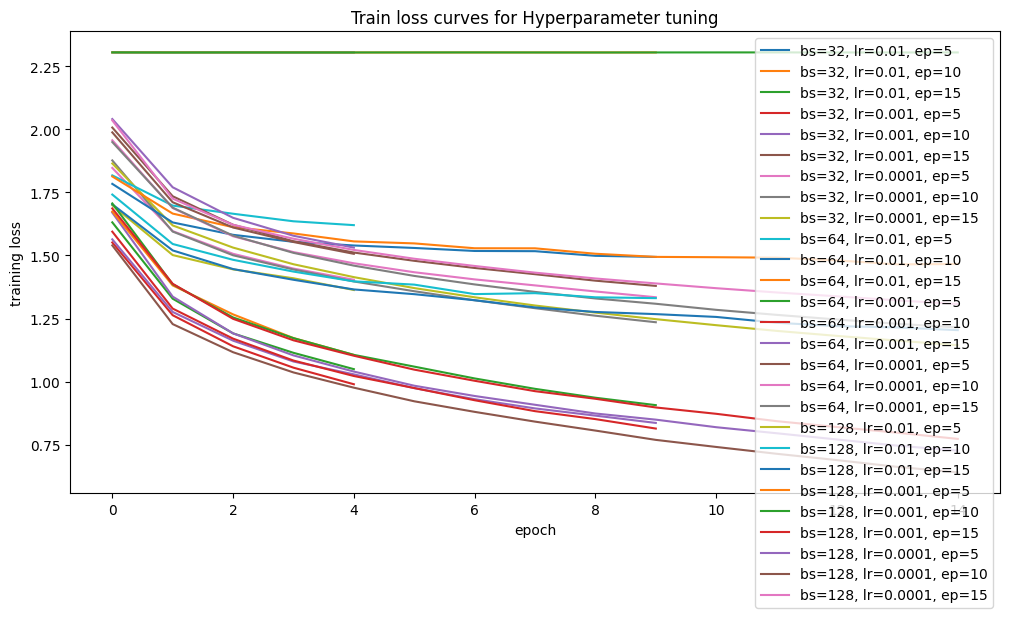

In [ ]:
plt.figure(figsize=(12, 6))
#plotting all the configs together
for config, val in results.items():
    bs, lr, ep = config
    plt.plot(val["train_loss"], label=f"bs={bs}, lr={lr}, ep={ep}")

plt.xlabel("epoch")
plt.ylabel("training loss")
plt.title("Train loss curves for Hyperparameter tuning")
plt.legend()
plt.show()


Hence  best con fig: (64, 0.001, 10)

best final testacc: 65.07